In [2]:
from PW_explorer.run_clingo import run_clingo
from PW_explorer.load_worlds import load_worlds
from PW_explorer.pwe_helper import rel_slicer
from PW_explorer.time_series import PWETimeSeriesModule
from PW_explorer.pwe_nb_helper import ASPRules
from PW_explorer.export import PWEExport
from PW_explorer.visualize import PWEVisualization

import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'
from copy import deepcopy
from collections import OrderedDict
import random
import csv

In [3]:
%load_ext PWE_NB_Extension

In [4]:
def turn_list_into_str(l):
    # small bug fix 
    if isinstance(l, (list,set,frozenset)):
        if len(l) > 1:
            l_ = [turn_list_into_str(l1) for l1 in l[1:]]
            return "{}({})".format(l[0], ",".join(l_))
        elif len(l) == 1:
            return "{}".format(l[0])
        else:
            return ""
    else:
        return l


In [5]:
def sql2clingo(sqlCommand,originalSchema,colour='black'):
    sql = sqlCommand.replace('"','')
    sqlList = sql.split(' ') 
    #print(sqlList)
    schemaList = originalSchema.split(',')
    #print(schemaList)
    clingoString = 0
    #print(sqlList[0])
    if sqlList[0] == 'UPDATE':
        sql = sql.replace(' = ','=')
        sql = sql.replace(' > ','>')
        sql = sql.replace(' < ','<')
        sql = sql.replace(' >= ','>=')
        sql = sql.replace(' <= ','<=')
        sql = sql.replace(',','')
        sqlList = sql.split(' ') 
        setLoc = sqlList.index('SET')
        whereLoc = sqlList.index('WHERE')
        setCommands = sqlList[setLoc+1:whereLoc]
        setCommands = [x.upper() for x in setCommands]
        whereCommands = sqlList[whereLoc+1:]
        whereCommands = [x.upper() for x in whereCommands if x != 'AND']
        whereCommandsString = '-'.join(whereCommands)
        whereCommandsComma = ','.join(whereCommands)
        setLocs = [x[:x.index('=')] for x in setCommands]
        setValues = [x[x.index('=')+1:] for x in setCommands]
        setVals = []
        startSetVals = []
        for x in (schemaList):
            if x in setLocs:
                loc = setLocs.index(x)
                setVals.append(setValues[loc])
                startSetVals.append('_')
            else:
                setVals.append(x)
                startSetVals.append(x)
        setValsString = ','.join(setVals)
        #clingoString = 'data('+setValsString+',black,"'+whereCommandsString+'",'+originalSchema+') :- data('+originalSchema+',_,_,_,_,_,_,_,_,_),'+whereCommandsComma+'.'
        clingoString = 'e(data('+setValsString+',prov(P,"'+whereCommandsString+'")),data('+originalSchema+',P),trans('+colour+',"'+whereCommandsString+'")) :- data('+originalSchema+',P),'+whereCommandsComma+'.'
    if sqlList[0] == 'INSERT':
        locator = 'VALUES('
        loc1 = sql.index(locator)
        loc2 = sql[loc1:].index(')')+loc1
        datavalues = sql[loc1+len(locator):loc2]
        datavaluesDash = datavalues.replace(',','-')
        clingoString = 'data('+datavalues+',"INSERT'+datavaluesDash+'").'
    
    return clingoString

In [6]:
def makeOriginal(dataValues,colour='black'):
    clingoStart = []
    for x in dataValues:
        clingoStart.append('data('+','.join(x)+',"").')
    return clingoStart

In [7]:
def addConversion(dataValues):
    variables = []
    spaces = ['_']*len(dataValues)
    #underscores = ','.join(spaces)
        
    variables = [chr(65+x) for x in range(len(dataValues))]
    clingoHead = 'data('+','.join(variables)+',P) :-'
    clingoBody = 'e(data('+','.join(variables)+',P),data('+','.join(spaces)+',_),trans(_,_)).'
    
    
    return clingoHead+clingoBody

In [8]:
def smallConvert(string):
    b = string.replace('data(','')
    b = b[:-1]
    c = b.replace('),',')\n')
    return c

In [9]:
def cleanCSVFile(csv,outCSV):
    with open(csv,'r') as f:
        data = f.read()
    dataNew = data.replace('(','')
    dataNew2 = dataNew.replace(')','')
    with open(outCSV,'w') as f:
        f.write(dataNew2)
    print(dataNew2)

In [10]:
originalSchema = 'id,a0,a1,a2,a3,a4,a5'.upper()

In [11]:
testDataNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows1000_Nqueries10.csv']
testQueryNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows100_Nqueries10.csv','/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows1000_Nqueries10.csv']

In [25]:
testDataNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries10.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries20.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows10_Nqueries30.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows50_Nqueries10.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows50_Nqueries20.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows50_Nqueries30.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries10.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries20.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixData_Nrows100_Nqueries30.csv']
testQueryNames = ['/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries10.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries20.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows10_Nqueries30.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows50_Nqueries10.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows50_Nqueries20.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows50_Nqueries30.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows100_Nqueries10.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows100_Nqueries20.csv', '/home/mj1e16/abduction/pwe/jupyterNotebooks/notInPWEenv/qfixQueries_Nrows100_Nqueries30.csv']

In [48]:
testData = testDataNames[1]
testQueries = testQueryNames[1]

In [49]:
cleanCSVFile(testData,'testData.csv')
testData = 'testData.csv'

0, 13, 85, 77, 27, 52, 48
1, 65, 79, 11, 5, 85, 46
2, 76, 1, 46, 73, 26, 95
3, 91, 4, 4, 56, 95, 41
4, 21, 43, 4, 24, 46, 52
5, 23, 24, 23, 48, 32, 7
6, 84, 56, 65, 21, 100, 87
7, 12, 34, 73, 72, 94, 45
8, 83, 68, 32, 60, 89, 86
9, 51, 59, 5, 26, 81, 44


In [50]:
dataSet = []
with open(testData,'r') as csvfile:
    reader = csv.reader(csvfile,delimiter=' ',quotechar='|')
    for row in reader:
        dataSet.append([' '.join(row)])

originalSetup = makeOriginal(dataSet)

with open(testQueries,'r') as f:
    data = f.read()
#print(data)    
queries = data.split('\n')
#print(queries)

commands = []
for x in queries:
    clingoString = sql2clingo(x,originalSchema)
    if clingoString != 0:
        commands.append(clingoString)
        
edgeNodeConv = addConversion(originalSchema.split(','))

clingo_rules = ['% schema data('+originalSchema+',prov)','% schema e(DATAEND,DATASTART,TRANS)']
clingo_rules.extend(originalSetup)
clingo_rules.extend(commands)
clingo_rules.extend([edgeNodeConv])



In [51]:
print(queries)

['UPDATE synth_1_clean_0 SET a1 = 95, a2 = 91 WHERE a1 = 3 AND a5 = 2', 'UPDATE synth_1_clean_1 SET a1 = 38, a2 = 21 WHERE a1 >= 38 AND a1 < 48 AND a4 >= 2 AND a4 < 12', 'INSERT INTO synth_1_clean_2 VALUES(10,44,50,23,23,22,46)', 'INSERT INTO synth_1_clean_3 VALUES(11,2,84,56,64,18,100)', 'UPDATE synth_1_clean_4 SET a1 = 33, a2 = 72 WHERE a1 = 71 AND a5 = 94', 'UPDATE synth_1_clean_5 SET a1 = 67, a2 = 30 WHERE a1 >= 53 AND a1 < 63 AND a4 >= 80 AND a4 < 90', 'UPDATE synth_1_clean_6 SET a1 = 59, a2 = 3 WHERE a1 >= 22 AND a1 < 32 AND a4 >= 72 AND a4 < 82', 'UPDATE synth_1_clean_7 SET a1 = 55, a2 = 71 WHERE a1 = 68 AND a5 = 37', 'UPDATE synth_1_clean_8 SET a1 = 78, a2 = 52 WHERE a1 >= 35 AND a1 < 45 AND a4 >= 44 AND a4 < 54', 'INSERT INTO synth_1_clean_9 VALUES(12,4,71,99,59,39,17)', 'UPDATE synth_1_clean_10 SET a1 = 77, a2 = 54 WHERE a1 >= 78 AND a1 < 88 AND a4 >= 21 AND a4 < 31', 'UPDATE synth_1_clean_11 SET a1 = 58, a2 = 46 WHERE a1 >= 24 AND a1 < 34 AND a4 >= 49 AND a4 < 59', 'UPDATE s

In [52]:
ASPRules('\n'.join(commands))

'e(data(ID,A0,95,91,A3,A4,A5,prov(P,"A1=3-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=3-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=3,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(10,44,50,23,23,22,46,"INSERT10-44-50-23-23-22-46").\ndata(11,2,84,56,64,18,100,"INSERT11-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=68,A5=37.\ne(data(ID,A0,78,52,A3,A4,A5,prov(P,"A1>=35-A1<45-A4>=44-A4<54")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=35-A1<45-A4>=44-A4<54")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=35,A1<45,A4>=44,A4<54.\ndata(12,4,71,99,59,39,17,"INSERT12-4-71-99-59-39-17").\ne(data(ID,A0,77,54,A3,A4,A5,prov(P,"A1>=78-A1<88-A4>=21-A4<31")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=78-A1<88-A4>=21-A4<31")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=78,A1<88,A4>=21,A4<31.\ne(data(ID,A0,58,46,A3,A4,A5,prov(P,"A1>=24-A1<34-A4>=49-A4<59")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=24-A1<34-A4>=49-A4<59")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=24,A1<34,A4>=49,A4<59.\ne(data(ID,A0,79,82,A3,A4,A5,prov(P,"A1=89-A5=74")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=89-A5=74")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=89,A5=74.\ne(data(ID,A0,56,43,A3,A4,A5,prov(P,"A1>=5-A1<15-A4>=79-A4<89")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=5-A1<15-A4>=79-A4<89")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=5,A1<15,A4>=79,A4<89.\ne(data(ID,A0,50,48,A3,A4,A5,prov(P,"A1=36-A5=34")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=36-A5=34")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=36,A5=34.\ne(data(ID,A0,61,46,A3,A4,A5,prov(P,"A1>=2-A1<12-A4>=20-A4<30")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=2-A1<12-A4>=20-A4<30")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=2,A1<12,A4>=20,A4<30.\ndata(13,59,86,80,80,82,25,"INSERT13-59-86-80-80-82-25").\ne(data(ID,A0,8,1,A3,A4,A5,prov(P,"A1>=1-A1<11-A4>=68-A4<78")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=1-A1<11-A4>=68-A4<78")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=1,A1<11,A4>=68,A4<78.\ndata(14,11,63,34,7,16,53,"INSERT14-11-63-34-7-16-53").\ndata(15,27,71,45,32,47,2,"INSERT15-27-71-45-32-47-2").\ne(data(ID,A0,95,91,A3,A4,A5,prov(P,"A1=3-A5=2")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=3-A5=2")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=3,A5=2.\ne(data(ID,A0,38,21,A3,A4,A5,prov(P,"A1>=38-A1<48-A4>=2-A4<12")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=38-A1<48-A4>=2-A4<12")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=38,A1<48,A4>=2,A4<12.\ndata(10,44,50,23,23,22,46,"INSERT10-44-50-23-23-22-46").\ndata(11,2,84,56,64,18,100,"INSERT11-2-84-56-64-18-100").\ne(data(ID,A0,33,72,A3,A4,A5,prov(P,"A1=71-A5=94")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=71-A5=94")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1=71,A5=94.\ne(data(ID,A0,67,30,A3,A4,A5,prov(P,"A1>=53-A1<63-A4>=80-A4<90")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=53-A1<63-A4>=80-A4<90")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=53,A1<63,A4>=80,A4<90.\ne(data(ID,A0,59,3,A3,A4,A5,prov(P,"A1>=22-A1<32-A4>=72-A4<82")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1>=22-A1<32-A4>=72-A4<82")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1>=22,A1<32,A4>=72,A4<82.\ne(data(ID,A0,55,71,A3,A4,A5,prov(P,"A1=68-A5=37")),data(ID,A0,A1,A2,A3,A4,A5,P),trans(black,"A1=68-A5=37")) :- data(ID,A0,A1,A2,A3,A4,A5,P),A1

In [53]:
ASPRules('\n'.join(originalSetup))

'data(0, 13, 85, 77, 27, 52, 48,"").\ndata(1, 65, 79, 11, 5, 85, 46,"").\ndata(2, 76, 1, 46, 73, 26, 95,"").\ndata(3, 91, 4, 4, 56, 95, 41,"").\ndata(4, 21, 43, 4, 24, 46, 52,"").\ndata(5, 23, 24, 23, 48, 32, 7,"").\ndata(6, 84, 56, 65, 21, 100, 87,"").\ndata(7, 12, 34, 73, 72, 94, 45,"").\ndata(8, 83, 68, 32, 60, 89, 86,"").\ndata(9, 51, 59, 5, 26, 81, 44,"").'

In [54]:
ASPRules(edgeNodeConv)

'data(A,B,C,D,E,F,G,P) :-e(data(A,B,C,D,E,F,G,P),data(_,_,_,_,_,_,_,_),trans(_,_)).'

In [55]:
%clingo -l clingo_rules --saveto clingo_soln --save_meta_data_to meta_data --donot-display_input

KeyboardInterrupt: 

In [34]:
pw_rels_dfs, rel_schemas, pw_objs = load_worlds(asp_output=clingo_soln, meta_data=meta_data, reasoner='clingo',internal_facts_as_string=False)

Number of Models: 1


In [35]:
pwe_e3_new_format = pw_rels_dfs['e_3'].applymap(turn_list_into_str)
pwe_data3_new_format = pw_rels_dfs['data_8'].applymap(turn_list_into_str)

In [36]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

startNode = []
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    if len(row['prov']) == 2:
        startNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')

In [37]:
# start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

# insertNodeList = []
# insertNodeProv = []
# nodeDict = {}
# nodeDict["start"] = [x for x in startNode]
# num=0
# for i, row in pwe_data3_new_format.iterrows():
#     #print(len(row['prov']))
#     #insertBase = startNode
#     if 'INSERT' in row['prov'] :
#         insertNode = [x for x in startNode]
#         insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
#         #print(insertNode)
#         insertNodeList.append(insertNode)
#         insertNodeProv.append(row['prov'])
#         nodeDict[row['prov']] = insertNode

In [38]:
start_col_names = ['ID','A0','A1','A2','A3','A4','A5']

insertNodeList = []
insertNodeProv = []
nodeDict = {}
nodeNameDict = {}
insertNameDict = {}
nodeDict["start"] = [x for x in startNode]
nodeNameDict["start"] = 'Initial DB'
num=0
for i, row in pwe_data3_new_format.iterrows():
    #print(len(row['prov']))
    #insertBase = startNode
    if 'INSERT' in row['prov'] :
        insertNode = [x for x in startNode]
        insertNode.append('('+"{}".format(','.join([row[col] for col in start_col_names]))+')')
        #print(insertNode)
        insertNodeList.append(insertNode)
        insertNodeProv.append(row['prov'])
        nodeDict[row['prov']] = insertNode
        nodeNameDict[row['prov']] = 'insertView '+str(num)
        insertNameDict[row['prov']] = 'insertView '+str(num)
        num += 1

In [39]:
provTraces = []
for i, row in pw_rels_dfs['e_3'].iterrows():
    provTraces.append(row['DATAEND'][-1][1:])
    
print(provTraces)
#uniqueProvTraces = set(provTraces)

[['""', '"A0>=78-A0<88-A4>=87-A4<97"'], ['""', '"A0>=62-A0<72-A4>=84-A4<94"'], ['""', '"A4>=28-A4<38-A2>=18-A2<28"'], ['""', '"A4>=45-A4<55-A2>=75-A2<85"'], ['"INSERT12-90-80-74-91-77-79"', '"A4>=68-A4<78-A2>=65-A2<75"'], ['"INSERT10-82-4-4-63-28-53"', '"A4>=24-A4<34-A2>=3-A2<13"'], ['""', '"A1>=35-A1<45-A4>=44-A4<54"'], ['""', '"A1>=53-A1<63-A4>=80-A4<90"']]


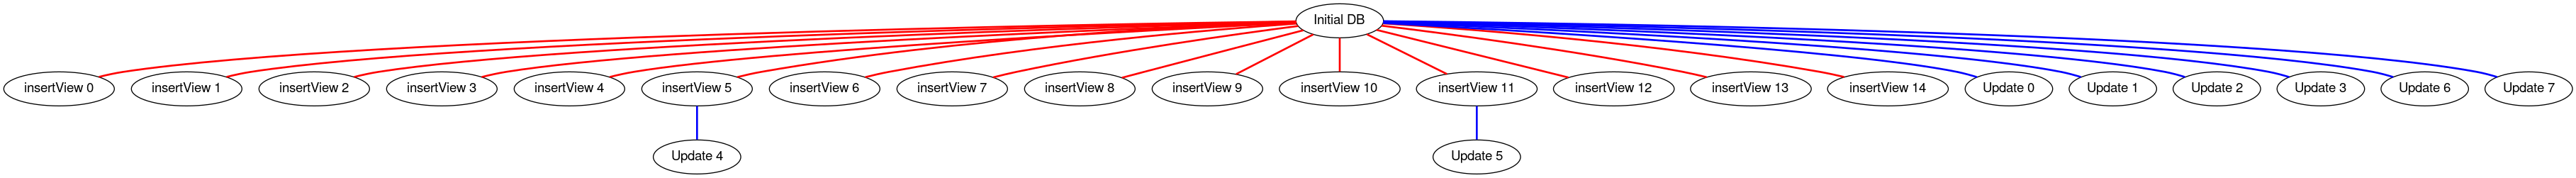

In [40]:
G = nx.Graph()
#start = '\n'.join(startNode) # for full db
start = 'Initial DB' # for names only

edges = []
provlist = []
num = 0
# for inserts in insertNodeList:
#     endInsert = '\n'.join(inserts)
#     G.add_edge(start,endInsert,penwidth=2,color='red')
#     edges.append((start,endInsert)) # for full values
    
for key,inserts in insertNameDict.items():
    endInsert = inserts
    G.add_edge(start,endInsert,penwidth=2,color='red')
    edges.append((start,endInsert)) # for names only
    
for prov in provTraces:
    startNodeSingle = []
    endNodeSingle = []
    startNode2Ignore = []
    
    for i, row in pw_rels_dfs['e_3'].iterrows():
        singleProv = [row['DATASTART'][-1],row['TRANS'][2]]
        if singleProv == prov:
            endNodeSingle.append('('+"{}".format(','.join(row['DATAEND'][1:-1])+')'))
            startNode2Ignore.append('('+"{}".format(','.join(row['DATASTART'][1:-1])+')'))
            startProv = row['DATASTART'][-1]

    provlist.append(startProv)
    if len(startProv) == 2:
        startProv = 'start'
    startNodeSingle = nodeDict[startProv] # for full data
    
    endNodeBase = [x for x in nodeDict[startProv] if x not in startNode2Ignore]
    endNodeBase.extend(endNodeSingle)
    
    #print(prov)
    prov = prov[1]
    nodeDict[prov] = endNodeBase
    nodeNameDict[prov] = 'Update '+str(num)
    
#     startNodeSingle = '\n'.join(startNodeSingle)# for full data
#     endNodeSingle = '\n'.join(endNodeBase)# for full data
    
    startNodeSingle = nodeNameDict[startProv] # names only
    endNodeSingle = nodeNameDict[prov] # names only
    G.add_edge(startNodeSingle,endNodeSingle,penwidth=2,color='blue')
    edges.append((startNodeSingle, endNodeSingle))
    num += 1

    
for node in G.nodes: G.nodes[node]['fontname'] = 'Helvetica'
#G.graph['layout'] = 'fdp'

draw(G)

In [41]:
start = nodeDict['start']
startNode = '\n'.join(start)

In [42]:
startNode = nodeNameDict['start']

In [43]:
nodeKeys = list(nodeNameDict.keys())
targetNum = 10
targets = []
for x in range(targetNum):
    targets.append(random.randint(0,len(nodeDict)-1))

targetPos = [nodeNameDict[nodeKeys[x]] for x in targets]
#targetNewFormat = ['\n'.join(t) for t in targetPos]

In [44]:
def getGraphStats(G,target,start):
    allPaths = []
    #for sources in dataValuesNonStr:
    singlePath = []
    for path in nx.all_simple_paths(G,source=start,target=target):
        singlePath.append(path)
    allPaths.append(singlePath)
    APP = len(allPaths[0])
    
    allPSorted = sorted(allPaths[0])
    allPSet = set(frozenset(x) for x in allPSorted)
    DIFF = [list(x) for x in allPSet]
    DIFFNUM = len(DIFF)
    
    minPath = nx.shortest_path(G,start,target)
    smallpp = len(minPath)
    
    return [APP,DIFFNUM,smallpp]

In [45]:
stats = getGraphStats(G,targetPos[0],startNode)

In [46]:
statyBojangles = []
for x in targetPos:
    statyBojangles.append(getGraphStats(G,x,startNode))

In [47]:
statyBojangles

[[1, 1, 3],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2],
 [1, 1, 2]]